## This notebook matches the initial xray catalog, refines down to only objects observed in DP1, and crossmatches to DP1 Object and diaObject table

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
import lsdb

from dask.distributed import Client
from io import StringIO
from nested_pandas import NestedDtype, read_parquet
from pathlib import Path

import warnings

# Disable plotting warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', 100)

In [3]:
def cast_nested(df, columns):
    return df.assign(
        **{
            col: df[col].astype(NestedDtype.from_pandas_arrow_dtype(df.dtypes[col]))
            for col in columns
        },
    )

In [4]:
dia_columns = ['dec', 'diaObjectId', 'nDiaSources', 'ra', 'radecMjdTai', 'tract', 'diaObjectForcedSource', 'diaSource'] + \
['g_psfFluxStetsonJ', 'r_psfFluxStetsonJ', 'u_psfFluxStetsonJ', 'i_psfFluxStetsonJ', 'z_psfFluxStetsonJ', 'y_psfFluxStetsonJ']

obj_columns = ['coord_dec', 'coord_decErr', 'coord_ra', 'coord_raErr', 'g_psfFlux', 'g_psfFluxErr', 'g_psfMag', 'g_psfMagErr', 
               'i_psfFlux', 'i_psfFluxErr', 'i_psfMag', 'i_psfMagErr', 'objectId', 'patch', 'r_psfFlux', 'r_psfFluxErr', 'r_psfMag',
               'r_psfMagErr', 'refBand', 'refFwhm', 'shape_flag', 'shape_xx', 'shape_xy', 'shape_yy', 'tract', 'u_psfFlux', 
               'u_psfFluxErr', 'u_psfMag', 'u_psfMagErr', 'x', 'xErr', 'y', 'y_psfFlux', 'y_psfFluxErr', 'y_psfMag', 'y_psfMagErr',
               'yErr', 'z_psfFlux', 'z_psfFluxErr', 'z_psfMag', 'z_psfMagErr', 'objectForcedSource', 'r_extendedness',
               'refExtendedness', 'refSizeExtendedness'] 

#### Run this cell on usdf rsp

In [5]:
# dia_catalog = lsdb.open_catalog('/epyc/data3/hats/catalogs/dp1/dia_object_collection/dia_object_lc', columns=dia_columns)
# dia_catalog = dia_catalog = dia_catalog.map_partitions(
#     cast_nested, columns=["diaSource", "diaObjectForcedSource"]
# )


# obj_catalog = lsdb.open_catalog("/sdf/data/rubin/shared/lsdb_commissioning/hats/v29_0_0/object_collection/object_lc")
# # We use the `cast_nested` utility method to cast columns into the NestedFrame type
# obj_catalog = obj_catalog.map_partitions(cast_nested, columns=["objectForcedSource"])

#### Run this cell on epyc

In [5]:
dia_catalog = lsdb.open_catalog('/epyc/data3/hats/catalogs/dp1/dia_object_collection/dia_object_lc', columns=dia_columns)
dia_catalog = dia_catalog = dia_catalog.map_partitions(
    cast_nested, columns=["diaSource", "diaObjectForcedSource"]
)

obj_catalog = lsdb.open_catalog('/epyc/data3/hats/catalogs/dp1/object_collection/object_lc', columns=obj_columns)
# We use the `cast_nested` utility method to cast columns into the NestedFrame type
obj_catalog = obj_catalog.map_partitions(cast_nested, columns=["objectForcedSource"])

### Run this cell on rsp
https://docs.lsdb.io/en/latest/tutorials/pre_executed/rubin_dp1.html

In [6]:
# from upath import UPath

# base_path = UPath("/rubin/lsdb_data")

# obj_catalog = lsdb.open_catalog(base_path / 'object_collection"/dia_object_lc', columns=dia_columns))
# dia_catalog = lsdb.open_catalog(base_path / 'dia_object_collection/', columns=obj_columns)

# dia_catalog = dia_catalog = dia_catalog.map_partitions(
#     cast_nested, columns=["diaSource", "diaObjectForcedSource"]
# )

# # We use the `cast_nested` utility method to cast columns into the NestedFrame type
# obj_catalog = obj_catalog.map_partitions(cast_nested, columns=["objectForcedSource"])

In [7]:
df_X = pd.read_csv('../../data/intermediate_data_products/xray_in_DP1_patches.csv')
df_X = df_X[df_X['DP1_flag']]

# rename F_X to F so that after xmatch the col name is not F_X_X
df_X.rename({'F_X': 'F'}, axis=1, inplace=True)
len(df_X)

4481

# Begin crossmatching

In [8]:
xray_catalog = lsdb.from_dataframe(df_X)

### Match to objects

In [9]:
XMATCH_RADIUS_ARCSEC = 15
result_obj = xray_catalog.crossmatch(
    obj_catalog, radius_arcsec=XMATCH_RADIUS_ARCSEC, suffixes=["_X", ""], n_neighbors=10
)

column = "objectForcedSource"
result_obj = result_obj.query(
    f"~{column}.psfFlux_flag"
    f" and ~{column}.pixelFlags_saturated"
    f" and ~{column}.pixelFlags_cr"
    f" and ~{column}.pixelFlags_bad"
)

result_obj = result_obj[result_obj['_dist_arcsec'] < result_obj['e_pos_95_X']]

In [10]:
result_obj = result_obj.compute()

In [11]:
len(result_obj)

4513

In [12]:
result_obj.to_parquet('../../data/intermediate_data_products/obj_dp1_xmatch.parquet')

### Match to diaObjects

#### Need to restart kernel and free data before proceeding

In [13]:
XMATCH_RADIUS_ARCSEC = 15
result_dia = xray_catalog.crossmatch(
    dia_catalog, radius_arcsec=XMATCH_RADIUS_ARCSEC, suffixes=["_X", ""], n_neighbors=10
)

column = "diaObjectForcedSource"
result_dia = result_dia.query(
    f"~{column}.psfFlux_flag"
    f" and ~{column}.pixelFlags_saturated"
    f" and ~{column}.pixelFlags_cr"
    f" and ~{column}.pixelFlags_bad"
)

result_dia = result_dia[result_dia['_dist_arcsec'] < result_dia['e_pos_95_X']]

In [14]:
result_dia = result_dia.compute()

In [15]:
len(result_dia)

2276

In [16]:
result_dia.to_parquet('../../data/intermediate_data_products/dia_dp1_xmatch.parquet')

## Use convex hull to eliminate unobserved sources around the edges

In [17]:
df_X['obj_flag'] = [x in result_obj.name_X.values for x in df_X.name]
df_X['dia_flag'] = [x in result_dia.name_X.values for x in df_X.name]

In [18]:
df_X[df_X['obj_flag'] | df_X['dia_flag']]

,name,ra,dec,e_pos_raw,field,cat,F,e_pos_1sig,e_pos_95,tract,patch,DP1_flag,obj_flag,dia_flag
5,4XMM J033247.8-274233,53.199541,-27.709182,0.099558,ECDFS,4XMMDR14,4.309243e-14,0.106707,0.209146,5063,34,True,True,False
7,4XMM J033259.8-274748,53.249388,-27.796770,0.102984,ECDFS,4XMMDR14,2.229586e-14,0.110379,0.216344,5063,34,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4478,4XMM J033312.9-275650,53.303807,-27.947326,6.915638,ECDFS,4XMMDR14,3.557987e-14,7.412259,14.528028,5063,23,True,True,True
4479,XMMSL3 J033018.4-282427,52.576750,-28.407410,7.445101,ECDFS,XMMSL3,1.705860e-12,7.445101,14.592398,4848,82,True,True,True


checks:  19 19
checks:  2136 2136
checks:  85 85
checks:  32 32
checks:  14 14
checks:  28 28


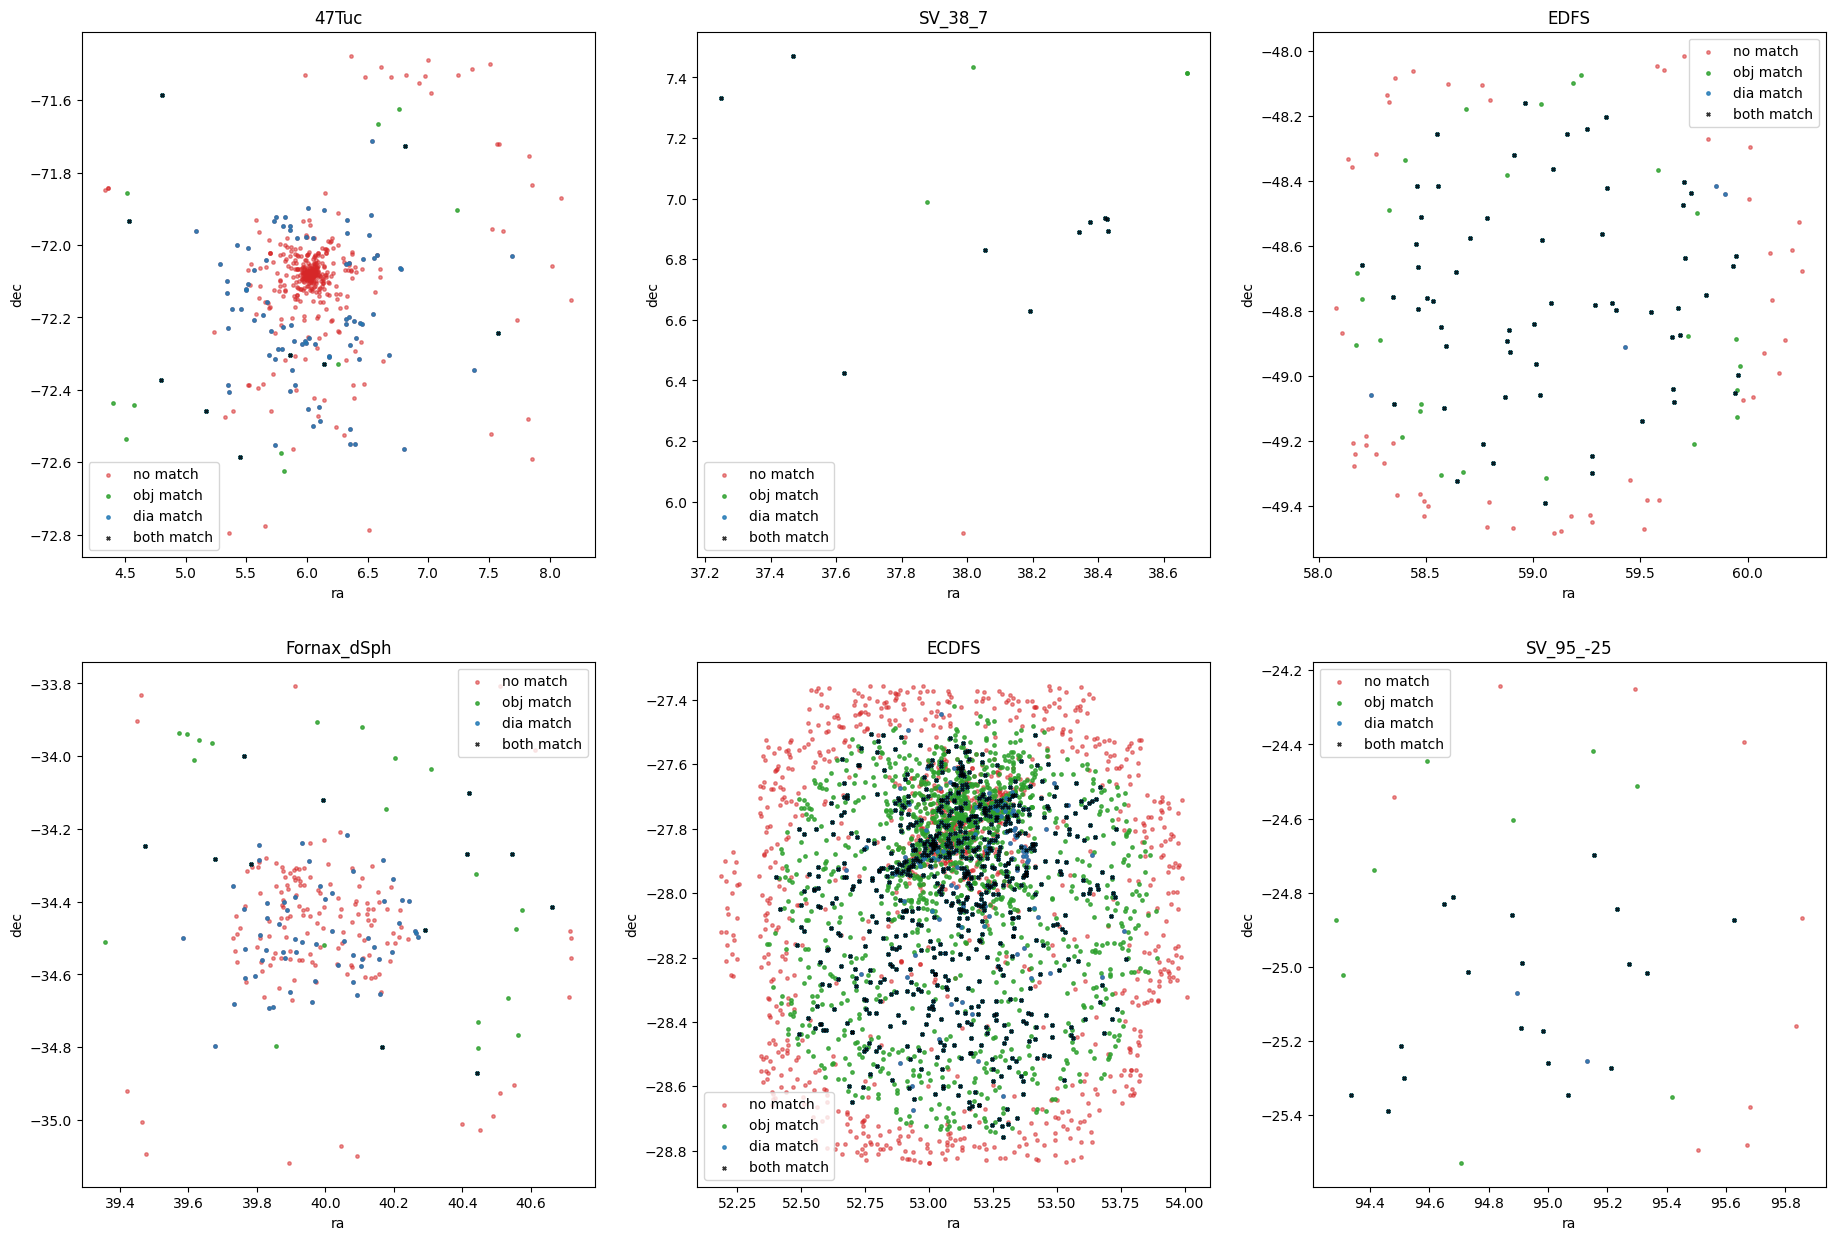

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(22.5, 15))
FIELDS = ['47Tuc', 'ECDFS', 'EDFS', 'Fornax_dSph', 'SV_38_7', 'SV_95_-25']
for i, field in enumerate(FIELDS):
    row = i%2
    col = i%3
    # observed = ind_df[ind_df['DP1_flag']]
    ind_field = df_X.query(f'field == "{field}"')
    matches_field = result_obj.query(f'field_X == "{field}"')
    
    print("checks: ", len(matches_field['name_X'].unique()), sum(ind_field['obj_flag']))
    
    ind_field[~ind_field['obj_flag']].plot.scatter(x='ra', y='dec', s=6, ax=axs[row, col],alpha=.5, color='tab:red', label='no match')
    ind_field[ind_field['obj_flag']].plot.scatter(x='ra', y='dec', s=6, ax=axs[row, col],alpha=.8, color='tab:green', label='obj match')
    ind_field[ind_field['dia_flag']].plot.scatter(x='ra', y='dec', s=6, alpha=.8, ax=axs[row, col], color='tab:blue', label='dia match')
    ind_field[(ind_field['dia_flag'] & ind_field['obj_flag'])].plot.scatter(x='ra', y='dec', s=6, alpha=.8, ax=axs[row, col], marker='x', color='k', label='both match')

    axs[row,col].set_title(field)

In [21]:
from scipy.spatial import ConvexHull, Delaunay
import numpy as np
import pandas as pd

def get_obs_xray(df_field):
    # xray objects with counterparts in Object for diaObject catalogs (used to compute hull)
    points = df_field[df_field['obj_flag'] | df_field['dia_flag']][['ra', 'dec']].values
    hull = ConvexHull(points)
    
    # Create Delaunay triangulation from hull vertices
    hull_points = points[hull.vertices]
    delaunay = Delaunay(hull_points)
    
    # New points to check (e.g., full xray object DataFrame)

    new_points = df_field[['ra', 'dec']].values
    
    # Check if points are inside the convex hull
    inside = delaunay.find_simplex(new_points) >= 0  # Boolean mask
    
    # Get subset of points in the hull
    df_obs = df_field.copy()[inside]
    
    return df_obs

obs_dfs = []

for field in FIELDS:
    obs_dfs.append(get_obs_xray(df_X.query(f'field == "{field}"')))

df_X_obs = pd.concat(obs_dfs)

In [22]:
df_X_obs

,name,ra,dec,e_pos_raw,field,cat,F,e_pos_1sig,e_pos_95,tract,patch,DP1_flag,obj_flag,dia_flag
26,2CXO J002407.1-720545,6.029833,-72.096061,0.290000,47Tuc,CSC2.1,2.369000e-14,0.147959,0.290000,453,52,True,False,False
28,2CXO J002416.9-720427,6.070792,-72.074222,0.290000,47Tuc,CSC2.1,3.697000e-14,0.147959,0.290000,453,52,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4471,1eRASS J061708.6-245226,94.285935,-24.873899,7.230333,SV_95_-25,eRASS1,2.566530e-14,7.230333,14.171453,5525,33,True,True,False
4472,1eRASS J062000.2-251529,95.001072,-25.258297,7.263949,SV_95_-25,eRASS1,2.193181e-14,7.263949,14.237341,5526,8,True,True,True


checks:  19 19
checks:  2136 2136
checks:  85 85
checks:  32 32
checks:  14 14
checks:  28 28


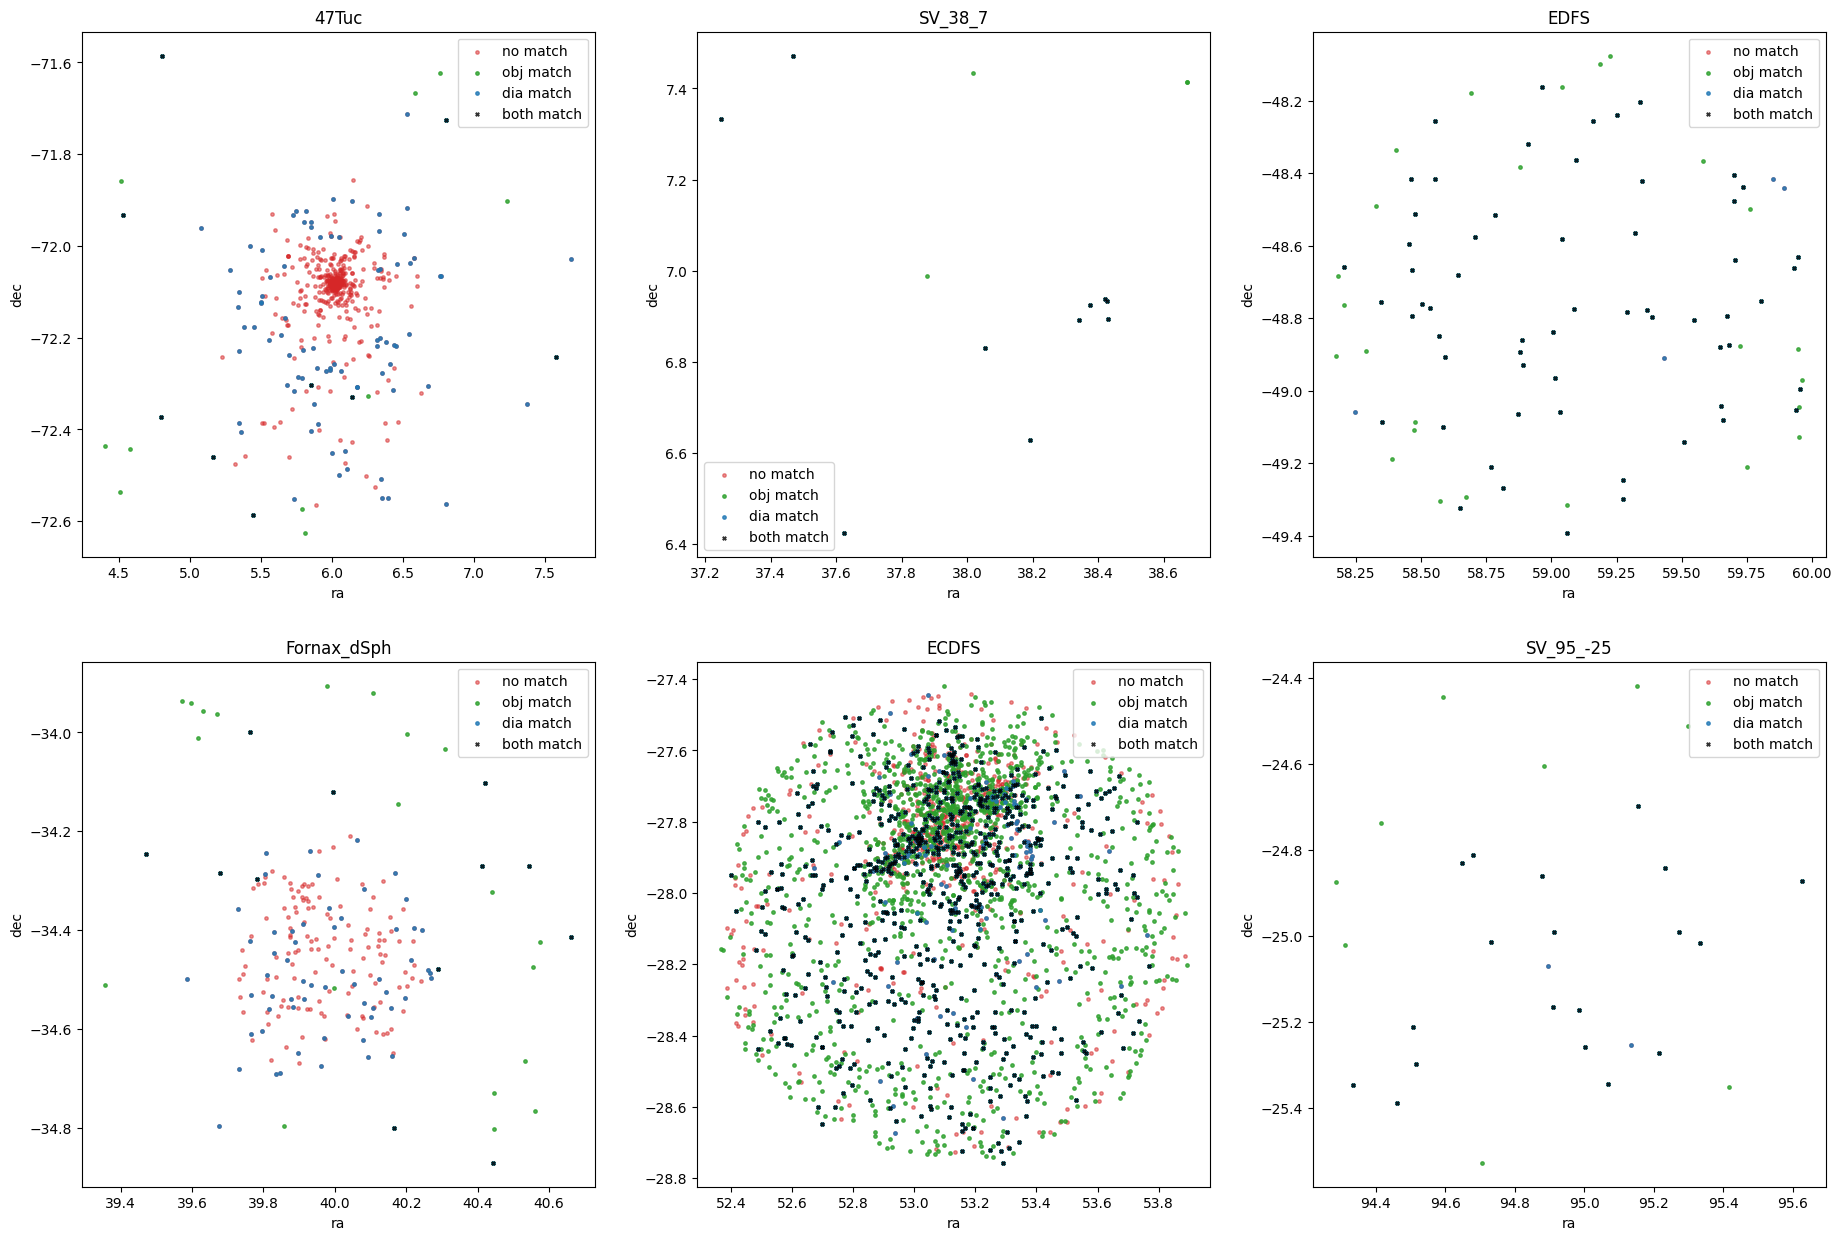

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(22.5, 15))
FIELDS = ['47Tuc', 'ECDFS', 'EDFS', 'Fornax_dSph', 'SV_38_7', 'SV_95_-25']
for i, field in enumerate(FIELDS):
    row = i%2
    col = i%3
    # observed = ind_df[ind_df['DP1_flag']]
    ind_field = df_X_obs.query(f'field == "{field}"')
    matches_field = result_obj.query(f'field_X == "{field}"')
    
    print("checks: ", len(matches_field['name_X'].unique()), sum(ind_field['obj_flag']))
    
    ind_field[~ind_field['obj_flag']].plot.scatter(x='ra', y='dec', s=6, ax=axs[row, col],alpha=.5, color='tab:red', label='no match')
    ind_field[ind_field['obj_flag']].plot.scatter(x='ra', y='dec', s=6, ax=axs[row, col],alpha=.8, color='tab:green', label='obj match')
    ind_field[ind_field['dia_flag']].plot.scatter(x='ra', y='dec', s=6, alpha=.8, ax=axs[row, col], color='tab:blue', label='dia match')
    ind_field[(ind_field['dia_flag'] & ind_field['obj_flag'])].plot.scatter(x='ra', y='dec', s=6, alpha=.8, ax=axs[row, col], marker='x', color='k', label='both match')

    axs[row,col].set_title(field)

# Save the df_X_obs dataframe (this is our final x-ray catalog)

In [24]:
# objectId is closest match
df_X_obs = df_X_obs.merge(result_obj.sort_values('_dist_arcsec', ascending=True).drop_duplicates(subset=['name_X'], keep='first')[['objectId', 'name_X']], left_on='name', right_on='name_X', how='left')

In [26]:
df_X_obs.drop('name_X', axis=1, inplace=True)

In [27]:
df_X_obs.to_csv('../../data/final_data_products/xray_in_DP1.csv', index=False) 

# Get random (control) matches from all_matches parquet

add 30 arcsecond offset and rematch to get a sample of field objects

In [28]:
random_pos = df_X_obs.copy()
random_pos['dec'] = random_pos['dec'] + 30 / 3600

random_pos = lsdb.from_dataframe(random_pos)

In [29]:
XMATCH_RADIUS_ARCSEC = 15
random_obj = random_pos.crossmatch(
    obj_catalog, radius_arcsec=XMATCH_RADIUS_ARCSEC, suffixes=["_X", ""], n_neighbors=10
)

column = "objectForcedSource"
random_obj = random_obj.query(
    f"~{column}.psfFlux_flag"
    f" and ~{column}.pixelFlags_saturated"
    f" and ~{column}.pixelFlags_cr"
    f" and ~{column}.pixelFlags_bad"
)
random_obj = random_obj[random_obj['_dist_arcsec'] < random_obj['e_pos_95_X']]

random_obj = random_obj.compute()

In [30]:
len(random_obj)

3101

In [31]:
XMATCH_RADIUS_ARCSEC = 15
random_dia = random_pos.crossmatch(
    dia_catalog, radius_arcsec=XMATCH_RADIUS_ARCSEC, suffixes=["_X", ""], n_neighbors=10
)

column = "diaObjectForcedSource"
random_dia = random_dia.query(
    f"~{column}.psfFlux_flag"
    f" and ~{column}.pixelFlags_saturated"
    f" and ~{column}.pixelFlags_cr"
    f" and ~{column}.pixelFlags_bad"
)
random_dia = random_dia[random_dia['_dist_arcsec'] < random_dia['e_pos_95_X']]

random_dia = random_dia.compute()

In [32]:
len(random_dia)

1734

In [33]:
random_obj.to_parquet('../../data/intermediate_data_products/obj_dp1_xmatch_random.parquet')
random_dia.to_parquet('../../data/intermediate_data_products/dia_dp1_xmatch_random.parquet')

# Value added crossmatches

In [34]:
obj = read_parquet('../../data/intermediate_data_products/obj_dp1_xmatch.parquet')
# dia = read_parquet('../../data/intermediate_data_products/dia_dp1_xmatch.parquet')

obj_pos = pd.DataFrame(obj[['coord_ra', 'coord_dec', 'objectId', 'field_X', 'name_X', 'cat_X', 'F_X']]).drop_duplicates()
obj_pos.rename({'coord_ra': 'ra', 'coord_dec': 'dec'}, axis=1, inplace=True)
obj_pos = lsdb.from_dataframe(obj_pos)

## milliQuas - Will need to download and load data into HATS format yourself
the match has been included in the repo

In [ ]:
# miliquas_cat = lsdb.read_hats(
#     "/sdf/data/rubin/user/olynn/AGNs/hats/Milliquas_v8",
#     margin_cache="/sdf/data/rubin/u/olynn/AGNs/hats/Milliquas_v8_margin/Milliquas_v8_10arcs",
# )

In [ ]:
# result_x_milliquas = obj_pos.crossmatch(miliquas_cat, suffixes=["", "_MIL"], radius_arcsec=1).compute()
# pd.DataFrame(result_x_milliquas).to_csv('../../data/final_data_products/obj_x_milliquas.csv', index=False)

In [35]:
result_x_milliquas = pd.read_csv('../../data/final_data_products/obj_x_milliquas.csv')

In [36]:
result_x_milliquas['field_X'].value_counts()

field_X
ECDFS      434
SV_38_7      5
EDFS         3
47Tuc        2
Name: count, dtype: int64

In [37]:
result_x_milliquas['cat_X'].value_counts()

cat_X
CSC2.1      317
4XMMDR14    117
2SXPS         6
eRASS1        4
Name: count, dtype: int64

## SIMBAD

In [38]:
from astroquery.simbad import Simbad
import astropy.units as u
from astropy.coordinates import SkyCoord

customSimbad=Simbad()
customSimbad.TIMEOUT = 600
customSimbad.add_votable_fields("otype(V)")
customSimbad.add_votable_fields("otype(3)")
# customSimbad.add_votable_fields("otype(N)")
# customSimbad.add_votable_fields("otype(S)")


customSimbad.add_votable_fields("flux(u)")
customSimbad.add_votable_fields("flux(g)")
customSimbad.add_votable_fields("flux(r)")
customSimbad.add_votable_fields("flux(i)")
customSimbad.add_votable_fields("flux(V)")
# customSimbad.add_votable_fields("flux(z)")
# customSimbad.add_votable_fields("flux(y)")

/tmp/ipykernel_2582805/2683171204.py:7: DeprecationWarning: 'otype(v)' has been renamed 'otypedef'. You will see this new name in the result.
  customSimbad.add_votable_fields("otype(V)")
/tmp/ipykernel_2582805/2683171204.py:8: DeprecationWarning: 'otype(3)' has been renamed 'otype'. You'll see it appearing with its new name in the output table
  customSimbad.add_votable_fields("otype(3)")
/tmp/ipykernel_2582805/2683171204.py:13: DeprecationWarning: The notation 'flux(u)' is deprecated since 0.4.8 in favor of 'u'. You will see the column appearing with its new name in the output. See section on filters in https://astroquery.readthedocs.io/en/latest/simbad/simbad_evolution.html to see the new ways to interact with SIMBAD's fluxes.
  customSimbad.add_votable_fields("flux(u)")
/tmp/ipykernel_2582805/2683171204.py:14: DeprecationWarning: The notation 'flux(g)' is deprecated since 0.4.8 in favor of 'g'. You will see the column appearing with its new name in the output. See section on filter

In [39]:
# customSimbad=Simbad()
# customSimbad.add_votable_fields("ident")

In [40]:
obj_pos

,ra,dec,objectId,field_X,name_X,cat_X,F_X
npartitions=3,,,,,,,
"Order: 5, Pixel: 34",double[pyarrow],double[pyarrow],int64[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],double[pyarrow]
"Order: 2, Pixel: 80",...,...,...,...,...,...,...
"Order: 0, Pixel: 8",...,...,...,...,...,...,...


In [41]:
sc = SkyCoord(obj_pos['ra'].values*u.degree, obj_pos['dec'].values*u.degree)

### Query SIMBAD in batches

In [42]:
end = len(sc)
n = 0
dfs = []
batch = 500
while n < end + batch:
    print(f'{min(n, end)}/{end}')
    if n > end:
        break
    else:
        query_df = (customSimbad.query_region(sc[n:min(n+batch, end)], radius=2*u.arcsecond))
    if query_df is None:
        n += batch
        continue
    else:
        query_df = query_df.to_pandas()

    dfs.append(query_df)
    n += batch
simbad_matches = pd.concat(dfs)

0/4513
500/4513
1000/4513
1500/4513
2000/4513
2500/4513
3000/4513
3500/4513
4000/4513
4500/4513
4513/4513


In [43]:
simbad_catalog = lsdb.from_dataframe(simbad_matches)

In [44]:
result_x_simbad = simbad_catalog.crossmatch(obj_pos, suffixes=["_SIM", ""], radius_arcsec=1, n_neighbors=1).compute()
result_x_simbad = result_x_simbad.drop_duplicates()

#### only keep 1:1 matches

In [45]:
result_x_simbad = result_x_simbad[~result_x_simbad.duplicated(subset=['objectId'], keep=False)]

In [46]:
len(result_x_simbad)

1046

In [47]:
pd.DataFrame(result_x_simbad).to_csv('../../data/final_data_products/obj_x_simbad.csv', index=False)

## Crossmatch to luo 2017

In [48]:
luo = pd.read_csv('../../data/raw_data/luo_2017_sources.csv')

In [49]:
luo.rename({'RAJ2000':'ra', 'DEJ2000':'dec'}, axis=1, inplace=True)

In [50]:
luo_catalog = lsdb.from_dataframe(luo)

In [51]:
(luo['errPos']*3).max()

np.float64(5.34)

#### 3 \sig xmatch

In [52]:
# obj_catalog = lsdb.open_catalog('/sdf/data/rubin/shared/lsdb_commissioning/hats/v29_0_0/object_collection')
obj_catalog = lsdb.open_catalog('/epyc/data3/hats/catalogs/dp1/object_collection/object_lc')
# We use the `cast_nested` utility method to cast columns into the NestedFrame type
obj_catalog = obj_catalog.map_partitions(cast_nested, columns=["objectForcedSource"])

In [53]:
XMATCH_RADIUS_ARCSEC = 5.34
result_luo = luo_catalog.crossmatch(
    obj_catalog, radius_arcsec=XMATCH_RADIUS_ARCSEC, suffixes=["", ""], n_neighbors=1
)

column = "objectForcedSource"
result_luo = result_luo.query(
    f"~{column}.psfFlux_flag"
    f" and ~{column}.pixelFlags_saturated"
    f" and ~{column}.pixelFlags_cr"
    f" and ~{column}.pixelFlags_bad"
)

result_luo = result_luo.compute()

print((result_luo['_dist_arcsec'] < result_luo['errPos']*3).sum())
result_luo = result_luo[result_luo['_dist_arcsec'] < result_luo['errPos']*3]

900


In [54]:
result_luo.to_parquet('../../data/intermediate_data_products/obj_x_luo.parquet')


## Crossmatch to Gaia DR3

In [55]:
gaia_cat = lsdb.open_catalog('/epyc/data3/hats/catalogs/gaia_dr3/')

In [56]:
result_x_gaia = obj_pos.crossmatch(gaia_cat, suffixes=["", "_GAIA"], radius_arcsec=.5).compute()
len(result_x_gaia)

345

In [59]:
pd.DataFrame(result_x_gaia).to_csv('../../data/final_data_products/obj_x_gaia_dr3.csv', index=False)

## Crossmatch to Gaia again to get all objectIds within 2 arcsec of a bright star

In [60]:
bright_gaia = obj_pos.crossmatch(gaia_cat, suffixes=["", "_GAIA"], radius_arcsec=2, n_neighbors=10)
bright_gaia = bright_gaia[bright_gaia['phot_g_mean_mag_GAIA'] < 15]
bright_gaia = bright_gaia.compute()


In [61]:
oids = bright_gaia['objectId'].drop_duplicates().values

## Create flag for objectIds near Gaia stars <15 Mag

In [62]:
obj['near_bright_flag'] = obj.objectId.isin(oids)

In [63]:
obj.to_parquet('../../data/intermediate_data_products/obj_dp1_xmatch.parquet')
